In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
import glob
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip
import time
import pickle
import collections
% matplotlib inline

In [12]:
def bin_spatial(img, size=(32, 32)):
    # Create the feature vector
    features = cv2.resize(img, size).ravel() 
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

Use HOG sub-sampling in different scales

In [13]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,demonstration=False):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    window_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if demonstration == True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                window_list.append(((xbox_left,  ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
            elif test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                 # Append window position to list
                window_list.append(((xbox_left,  ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def process_bboxes(image,hot_windows,threshold,show_heatmap=False):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)  
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    #draw_img = draw_labeled_bboxes(np.copy(image), labels)
    bbox_list = find_labeled_boxes(labels)
    if show_heatmap:
        return bbox_list,heatmap
    else:
        return bbox_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def find_labeled_boxes(labels):
    bbox_list = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_list.append(bbox)
    return bbox_list

def draw_car_boxes(img, bbox_list):
    for bbox in bbox_list:
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [14]:
test_images = glob.glob('test_images\*.jpg')

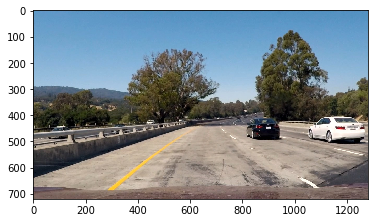

In [15]:
sample_test_image = mpimg.imread(test_images[0])
fig = plt.figure()
plt.imshow(sample_test_image)
plt.show()

In [16]:
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
global svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins,ystart,ystop
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
y_start_stop = [400, 600] # Min and max in y to search in slide_window()
ystart = y_start_stop[0]
ystop = y_start_stop[1]

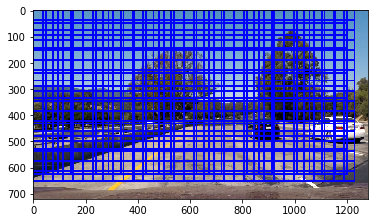

In [17]:
# The scales of sliding windows that HOG features will be computed 
scales = [2.4,3]
hot_windows = None
for scale in scales:
    if hot_windows is None:
        hot_windows = find_cars(sample_test_image, 0, 700, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,demonstration=True)
    else:
        hot_windows = hot_windows + find_cars(sample_test_image, 0, 700, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,demonstration=True)
img_draw = draw_boxes(sample_test_image, hot_windows, color=(0, 0, 255), thick=6)        

fig = plt.figure()
plt.imshow(img_draw)
plt.show()

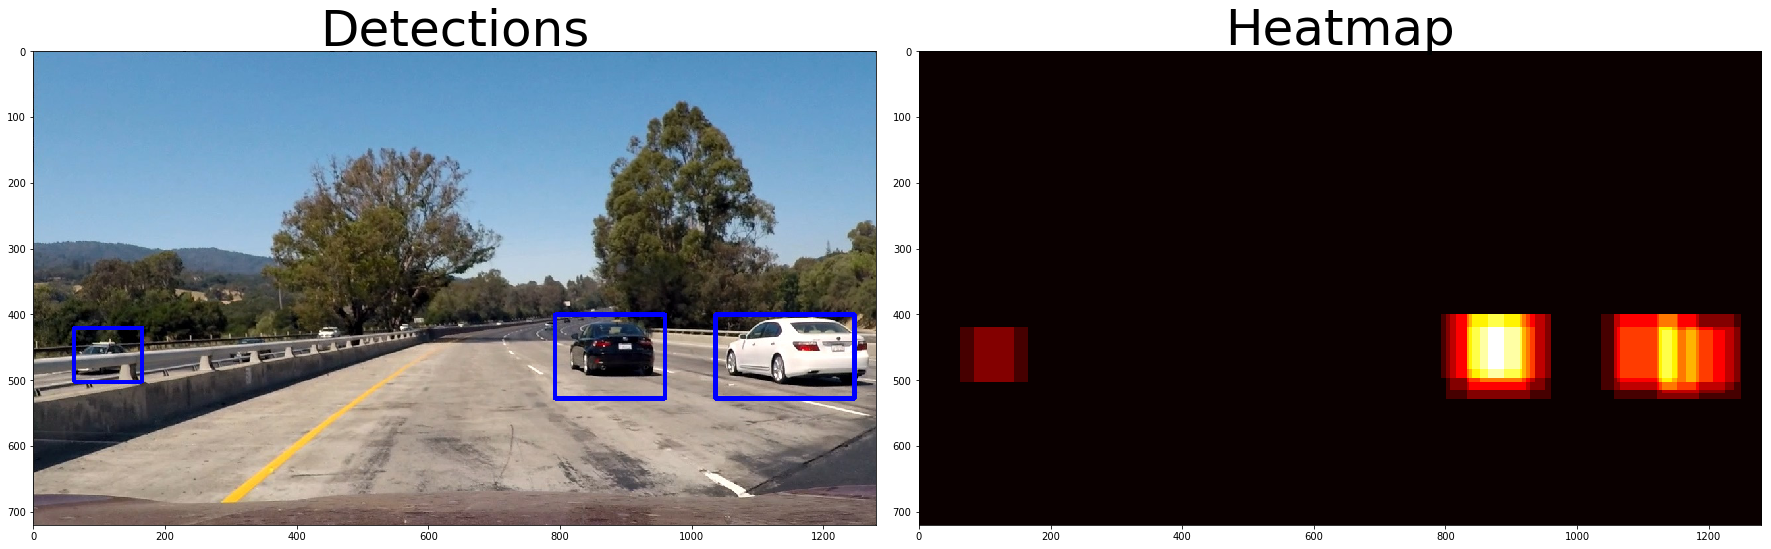

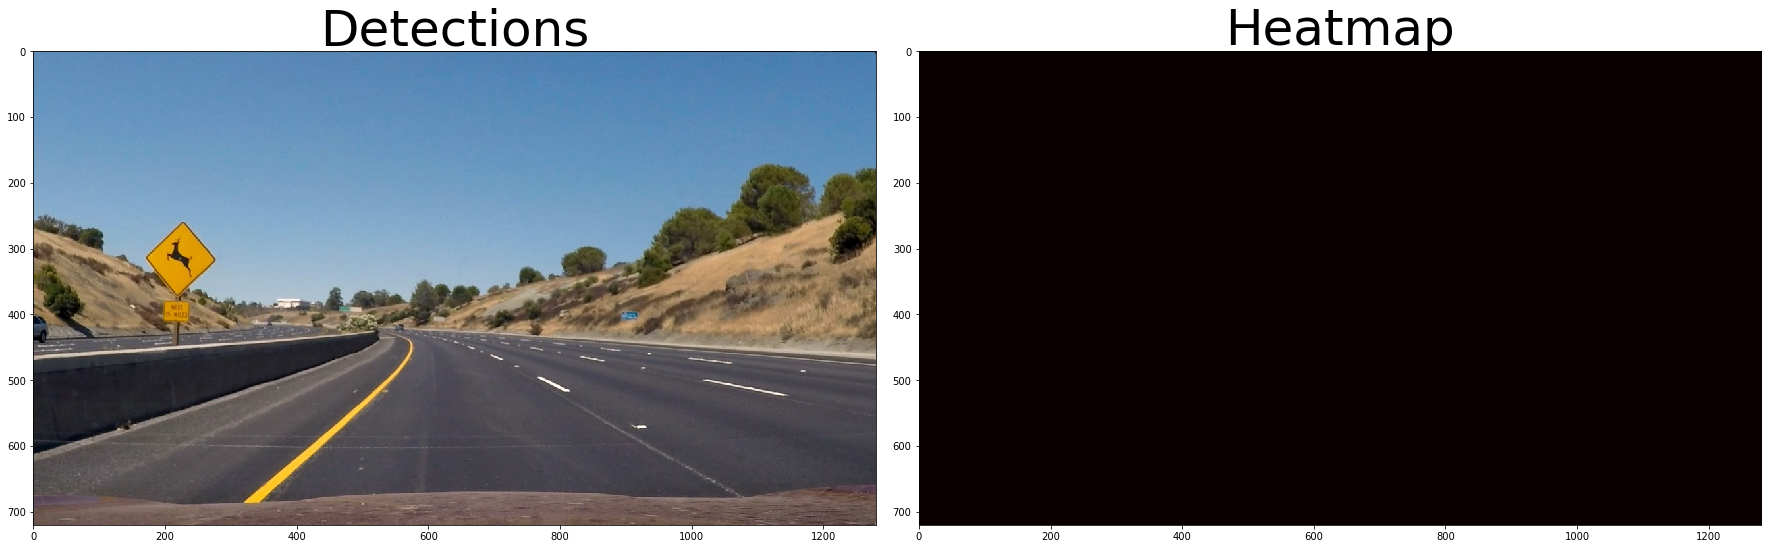

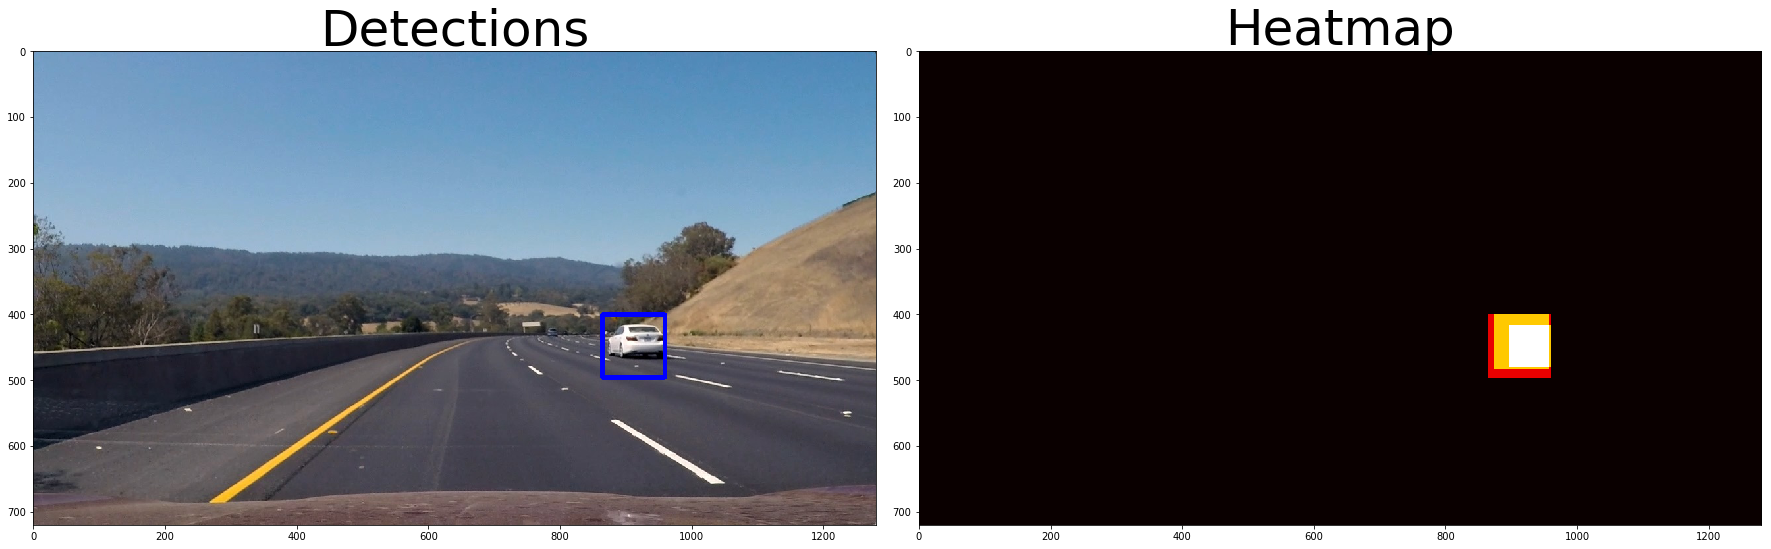

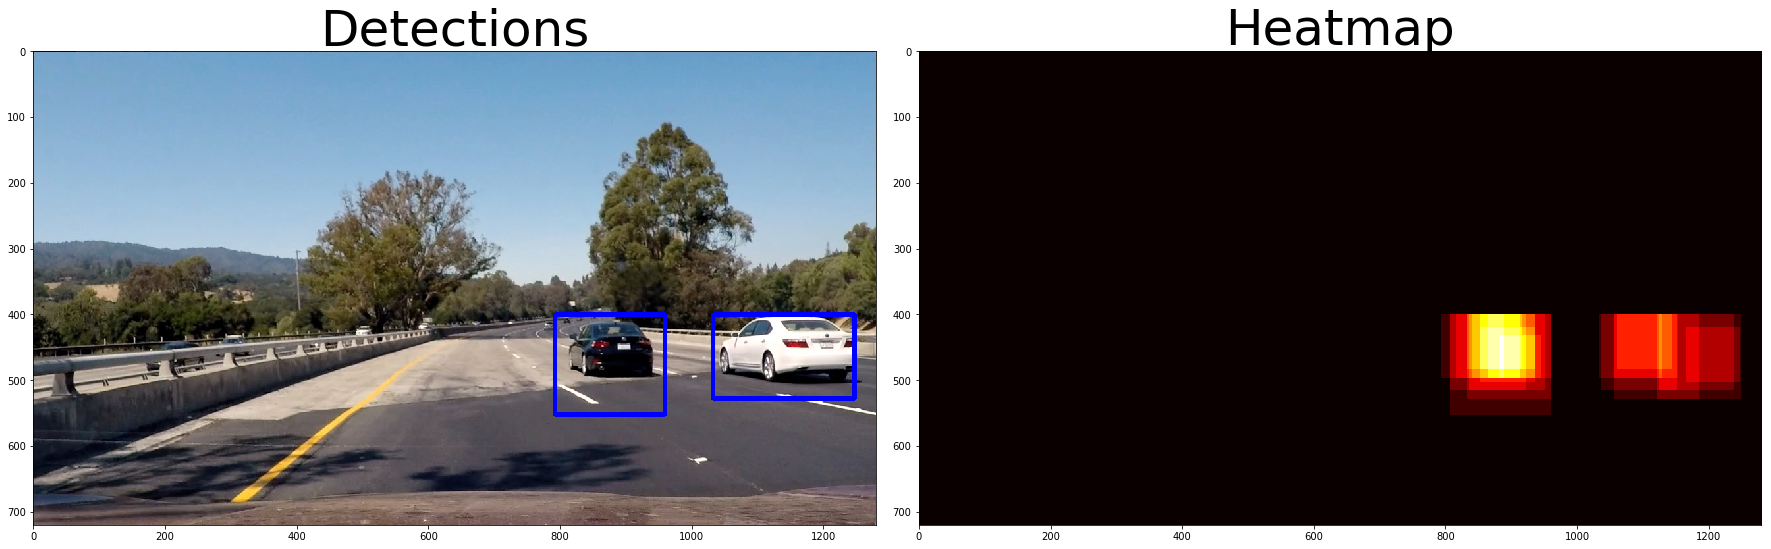

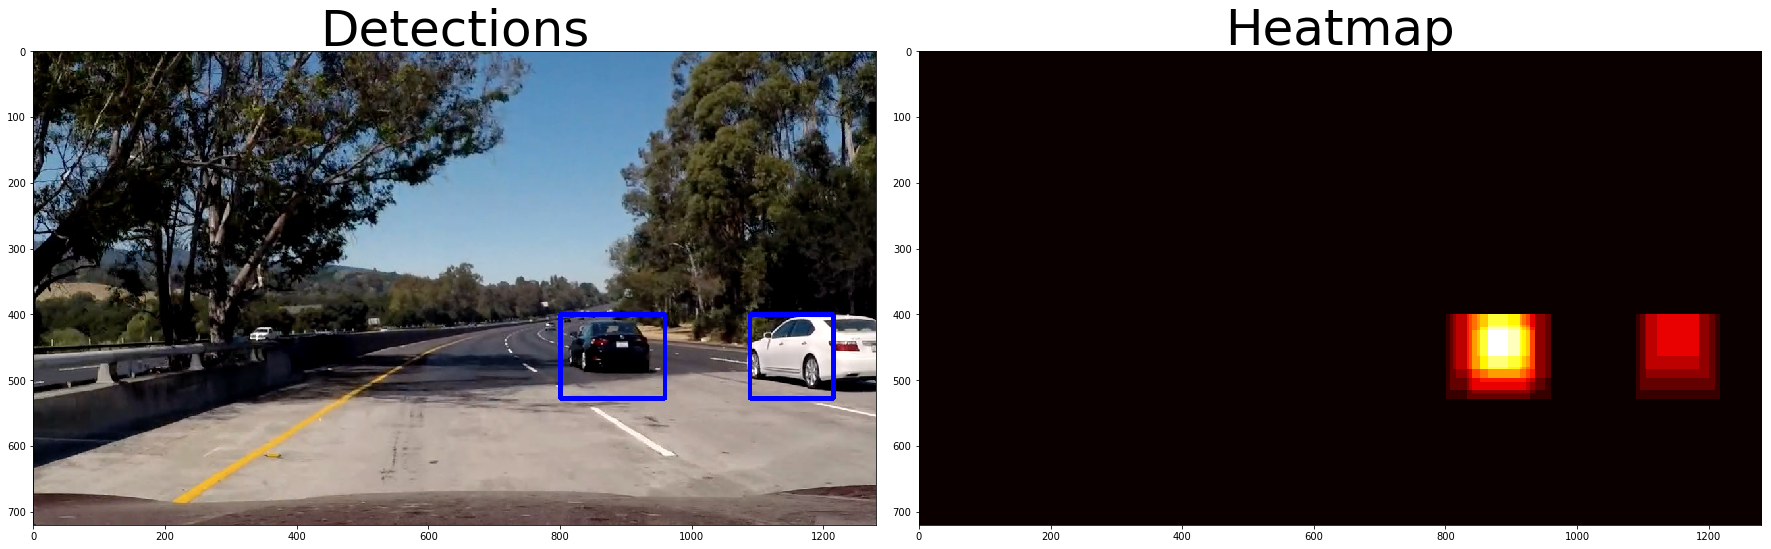

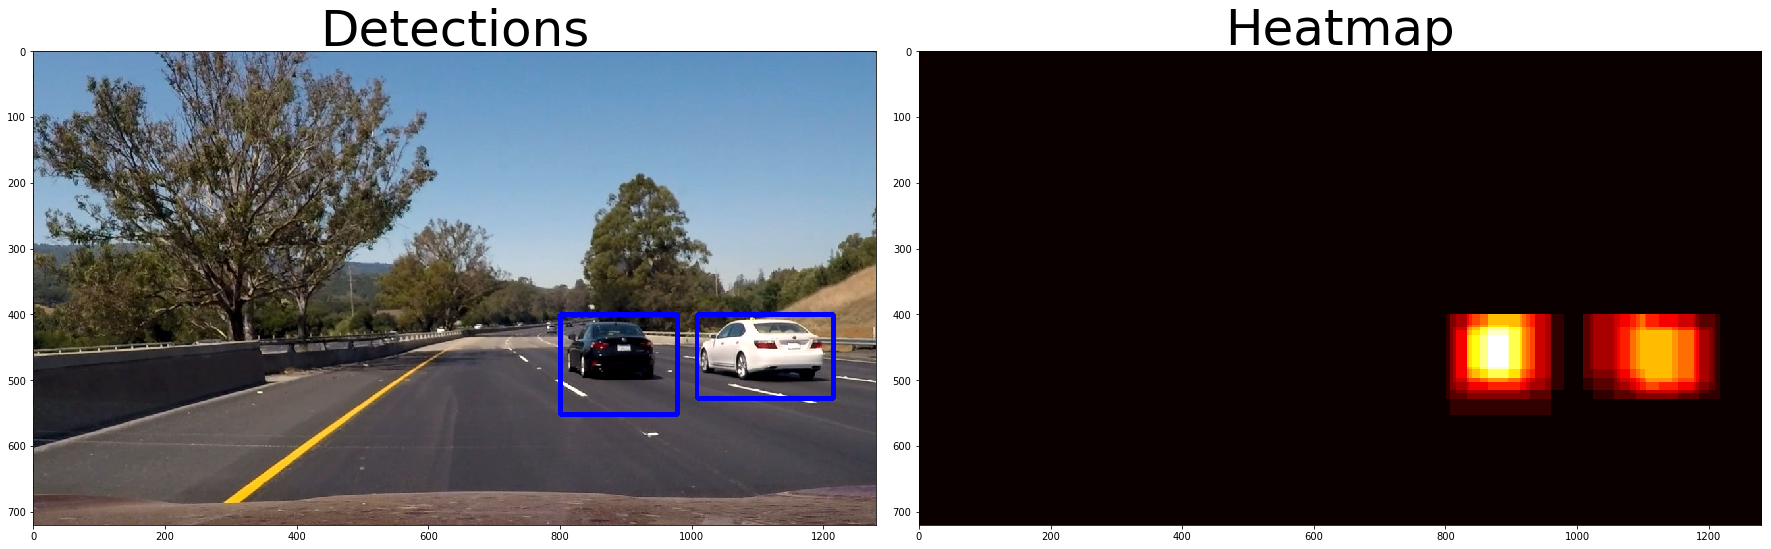

In [18]:
for img in test_images:
    image = mpimg.imread(img)
    scales = [1,1.3,1.5,1.8,2,2.4,3]
    hot_windows = None
    for scale in scales:
        if hot_windows is None:
            hot_windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        else:
            hot_windows = hot_windows + find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
     
    bbox_list,heatmap = process_bboxes(image,hot_windows,threshold=0,show_heatmap=True)
    draw_img = draw_car_boxes(image, bbox_list)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(draw_img)
    ax1.set_title('Detections', fontsize=50)
    ax2.imshow(heatmap,cmap='hot')
    ax2.set_title('Heatmap', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)      
    plt.savefig('output_images\\detection_on_test_images\\'+img.split('\\')[-1].split('.')[0]+'_detection.jpg')

In [19]:
def process_image( image, n_frames=10 ):
    if process_image.global_cache is None:
        buffered_bboxes = collections.deque(maxlen=n_frames)
        actual_boxes = collections.deque(maxlen=n_frames)
        global_cache= {
            'buffered_bboxes': buffered_bboxes,
            'actual_boxes':actual_boxes
        }        
    else:
        global_cache = process_image.global_cache
        buffered_bboxes = global_cache['buffered_bboxes']
        actual_boxes = global_cache['actual_boxes']
    # The scales of sliding windows that HOG features will be computed 
    scales = [1,1.3,1.5,1.8,2,2.4,3]
    # Apply all scales
    hot_windows = None
    for scale in scales:
        if hot_windows is None:
            hot_windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        else:
            hot_windows = hot_windows + find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    # Identify boxes using threshold to avoid false positives
    bbox_list = process_bboxes(image,hot_windows,threshold=0,show_heatmap=False)
    # Add to buffered list
    buffered_bboxes.append(bbox_list)
    # Append to global cache
    global_cache['buffered_bboxes'] = buffered_bboxes
    process_image.global_cache = global_cache
    # Get all buffered boxes
    avg_bbox_list=[]
    for box in buffered_bboxes:
        for b in box:
            avg_bbox_list.append(b)
    # Smoothing - Apply avg heatmap to further reduce false positives and smooth the bounding boxes
    bbox_list,heatmap = process_bboxes(image,avg_bbox_list,threshold=7,show_heatmap=True)         
    draw_img = draw_car_boxes(image, bbox_list)
    
    
    #Merge heatmap with image
    sizeX = int(256*1.3)
    sizeY = int(144*1.3)
    heat2 = cv2.resize(heatmap, (sizeX,sizeY))
    res_img = cv2.resize(image, (sizeX,sizeY))
    res_img_gray = cv2.cvtColor(res_img , cv2.COLOR_RGB2GRAY)
    
    heat3=(heat2/np.max(heat2)*255).astype(int)   
    
    res_img_gray_R=res_img_gray #np.zeros_like(res_img_gray)
    res_img_gray_R[(heat2>0)] =255
    #img_mag_thr[(imgThres_yellow==1) | (imgThres_white==1) | (imgThr_sobelx==1)] =1
    res_img_gray_G =res_img_gray
    res_img_gray_G[(heat2>0)] =0
    res_img_gray_B =res_img_gray
    res_img_gray_B[(heat2>0)] =0
    
    draw_img[0:sizeY,0:sizeX,0]=res_img_gray_R +heat3
    draw_img[0:sizeY,0:sizeX,1]=res_img_gray
    draw_img[0:sizeY,0:sizeX,2]=res_img_gray
    
    return draw_img

In [20]:
def clear_cache():
    process_image.global_cache = None

def create_video():
    clear_cache()
    vid_output = 'project_video_result.mp4'
    project_video = VideoFileClip('project_video.mp4')
    result_video = project_video.fl_image(process_image)
    result_video.write_videofile(vid_output, audio=False)

In [21]:
create_video()

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████████████████████████████████▉| 1260/1261 [42:48<00:01,  1.95s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

